In [1]:
import numpy as np
import xarray as xr
import jax.numpy as jnp
from jax import random
import numpyro
numpyro.enable_x64()
import arviz as az
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs

from src.model_fitting_functions import run_inference
from src.examples_functions import hierarchical_model_mask
from src.helper_functions import remove_outliers
from src.examples_functions import posterior_predictive_realisations_hierarchical_mean, posterior_predictive_realisations_hierarchical_var
from src.examples_functions import create_levels,hierarchical_model,truth_posterior_predictive,bias_posterior_predictive

rng_key = random.PRNGKey(5)
rng_key, rng_key_ = random.split(rng_key)

In [2]:
base_path = '/home/jez/Bias_Correction/'
obs_path = f'{base_path}data/ProcessedData/NST_Observations_Ross_Subset_Reformatted.nc'
climate_path = f'{base_path}data/ProcessedData/MetUM_Ross_Subset_Reformatted.nc'
mask_path = f'{base_path}data/ProcessedData/MetUM_044_Masks.nc'

ds_obs = xr.open_dataset(obs_path)
ds_climate = xr.open_dataset(climate_path)

ds_obs_stacked = ds_obs.stack(D=('Year','Day'))
sorting_axis = ds_obs_stacked["Temperature()"].dims.index('D')
ds_obs_stacked["Temperature()"].data = np.sort(ds_obs_stacked["Temperature()"].data, axis=sorting_axis) # sorting Nans to back
ds_obs_stacked = ds_obs_stacked.dropna('D','all').dropna('Station_Lower','all')
min_days_data_condition = (ds_obs_stacked.isnull()==False).sum('D')>100
ds_obs_stacked = ds_obs_stacked.where(min_days_data_condition,drop=True)
white_island_condition = (ds_obs_stacked.Station_Lower=='white-island')==False
ds_obs_stacked = ds_obs_stacked.where(white_island_condition,drop=True)
ds_obs_stacked['non_null_values'] = (ds_obs_stacked['Temperature()'].isnull()==False).sum('D')

ds_climate['tas']=ds_climate['tas']-273.15
ds_climate = remove_outliers(ds_climate['tas'].mean('time'),ds_climate, dims=['grid_latitude','grid_longitude'], perc=[0.02,0.98])
ds_climate = ds_climate.dropna('grid_latitude','all').dropna('grid_longitude','all')
ds_climate_stacked = ds_climate.stack(X=(('grid_longitude','grid_latitude'))).dropna('X','all')

obs_grid_longitudes = ds_obs_stacked.isel(D=0).grid_longitude
obs_grid_latitudes = ds_obs_stacked.isel(D=0).grid_latitude
ds_climate_nearest = ds_climate.sel(grid_longitude=obs_grid_longitudes,grid_latitude=obs_grid_latitudes,method='nearest')
da_difference_mean = ds_climate_nearest.tas.mean('time') - ds_obs_stacked['Temperature()'].mean('D')
da_difference_var = ds_climate_nearest.tas.var('time') - ds_obs_stacked['Temperature()'].var('D')
da_difference_logvar = np.log(ds_climate_nearest.tas.var('time')) - np.log(ds_obs_stacked['Temperature()'].var('D'))
ds_obs_stacked['Difference Nearest Mean'] = (('Station_Lower'), da_difference_mean.data)
ds_obs_stacked['Difference Nearest Var'] = (('Station_Lower'), da_difference_var.data)
ds_obs_stacked['Difference Nearest LogVar'] = (('Station_Lower'), da_difference_logvar.data)

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [3]:
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)
antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


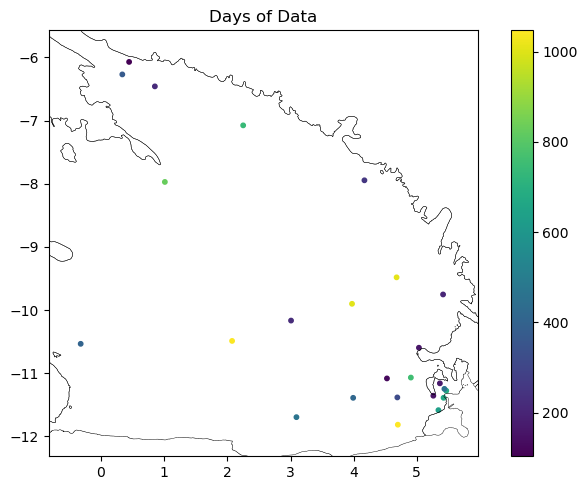

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
da = ds_obs_stacked['non_null_values']
s=10
plot = ax.scatter(x=da.glon,y=da.glat,c=da,s=s)

min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
ax.set_xlim([min_glon, max_glon])
ax.set_ylim([min_glat, max_glat])
antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

plt.colorbar(plot)
plt.title('Days of Data')
plt.tight_layout()

In [5]:
ox = np.vstack(
    [
        ds_obs_stacked.glon.data,
        ds_obs_stacked.glat.data,
    ]
).T  # shape = [sites,2]
odata = jnp.array(ds_obs_stacked['Temperature()'].data).T
omask = jnp.logical_not(jnp.isnan(odata)) 

cx = np.vstack(
    [
        ds_climate_stacked.glon.data,
        ds_climate_stacked.glat.data,
    ]
).T  # shape = [sites,2]
cdata = ds_climate_stacked.tas.data

print(f'ox shape = {ox.shape}')
print(f'cx shape = {cx.shape}')
print(f'odata shape = {odata.shape}')
print(f'cdata shape = {cdata.shape}')
print(f'ox mean = {ox.mean()}')
print(f'cx mean = {cx.mean()}')
print(f'odata mean = {odata[omask==1].mean()}')
print(f'cdata mean = {cdata.mean()}')
print(f'odata std = {odata[omask==1].std()}')
print(f'cdata std = {cdata.std()}')

ox shape = (25, 2)
cx shape = (206, 2)
odata shape = (1047, 25)
cdata shape = (1178, 206)
ox mean = -3.1610728526014698
cx mean = -4.076408659370209
odata mean = -6.6667362652099795
cdata mean = -7.90401029586792
odata std = 3.260391107090907
cdata std = 3.4111924171447754
odata std = 3.260391107090907
cdata std = 3.4111924171447754


/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


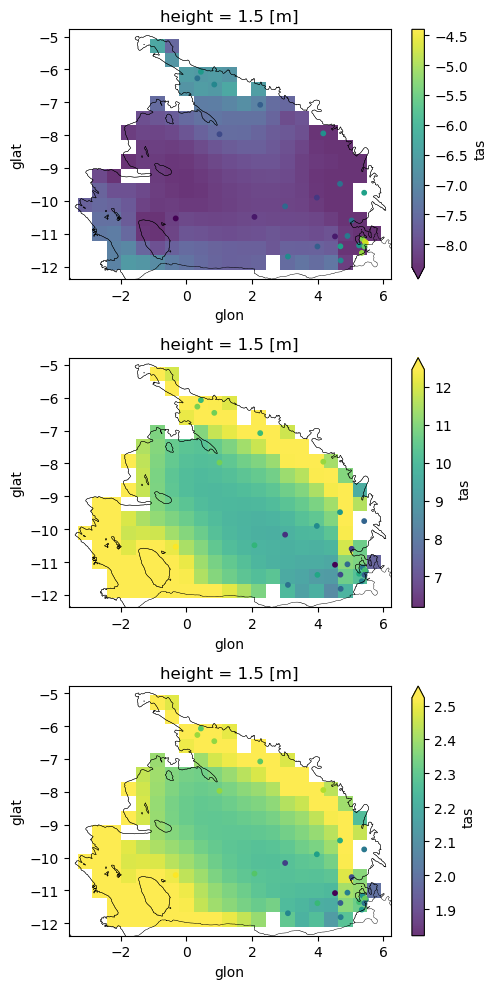

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
da = ds_climate['tas']
s=10
vmin_mean = min(np.nanmean(odata,axis=0))
vmax_mean = max(np.nanmean(odata,axis=0))
vmin_var = min(np.nanvar(odata,axis=0))
vmax_var = max(np.nanvar(odata,axis=0))
vmin_logvar = min(np.log(np.nanvar(odata,axis=0)))
vmax_logvar = max(np.log(np.nanvar(odata,axis=0)))

da.mean('time').plot.pcolormesh(x='glon',y='glat',ax=axs[0],alpha=0.8,vmin=vmin_mean,vmax=vmax_mean)
axs[0].scatter(x=ox[:,0],y=ox[:,1],c=np.nanmean(odata,axis=0),vmin=vmin_mean,vmax=vmax_mean,s=s)

da.var('time').plot.pcolormesh(x='glon',y='glat',ax=axs[1],alpha=0.8,vmin=vmin_var,vmax=vmax_var)
axs[1].scatter(x=ox[:,0],y=ox[:,1],c=np.nanvar(odata,axis=0),vmin=vmin_var,vmax=vmax_var,s=s)

np.log(da.var('time')).plot.pcolormesh(x='glon',y='glat',ax=axs[2],alpha=0.8,vmin=vmin_logvar,vmax=vmax_logvar)
axs[2].scatter(x=ox[:,0],y=ox[:,1],c=np.log(np.nanvar(odata,axis=0)),vmin=vmin_logvar,vmax=vmax_logvar,s=s)

min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

plt.tight_layout()

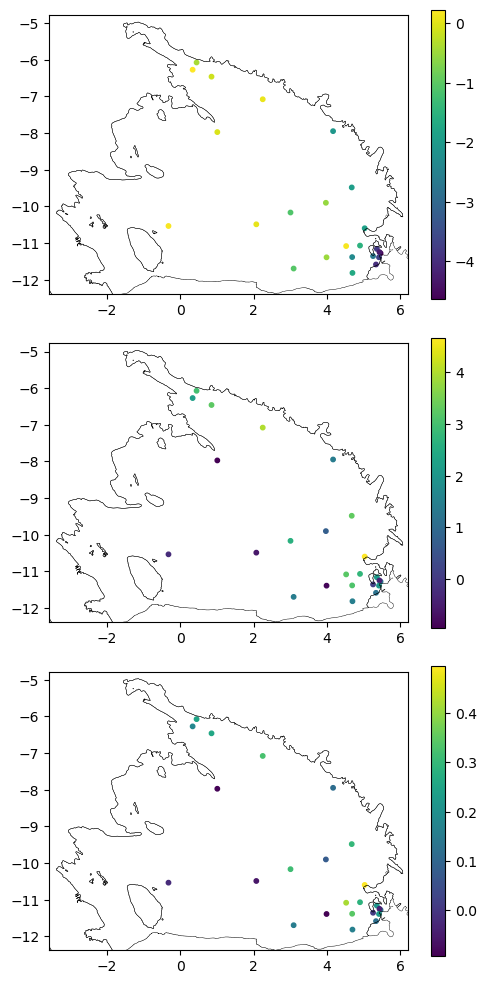

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
s=10
plots=[]
plots.append(axs[0].scatter(x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,c=ds_obs_stacked['Difference Nearest Mean'],s=s))
plots.append(axs[1].scatter(x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,c=ds_obs_stacked['Difference Nearest Var'],s=s))
plots.append(axs[2].scatter(x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,c=ds_obs_stacked['Difference Nearest LogVar'],s=s))

min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

for plot in plots:
    plt.colorbar(plot)
plt.tight_layout()

In [8]:
cdata_sample = cdata[::5]
om_noise = 1e-4
cm_noise = 1e-4
olv_noise = 1e-4
clv_noise = 1e-4

mcmc_hierarchical = run_inference(
    hierarchical_model_mask, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata_sample,odata=odata,obs_mask=omask,
    om_noise=om_noise,cm_noise=cm_noise,olv_noise=olv_noise,clv_noise=clv_noise)

sample: 100%|██████████| 3000/3000 [1:25:04<00:00,  1.70s/it, 255 steps of size 4.28e-02. acc. prob=0.87]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
     lvb_kern_var      1.43      1.12      1.14      0.07      2.95   1088.15      1.00
  lvb_lengthscale      6.48      3.59      5.16      2.71     11.90    365.48      1.00
         lvb_mean      0.02      0.77      0.00     -1.24      1.31   2315.10      1.00
           lvc[0]      2.70      0.04      2.70      2.63      2.77   1482.47      1.00
           lvc[1]      2.71      0.03      2.72      2.66      2.77   1042.30      1.00
           lvc[2]      2.67      0.03      2.67      2.62      2.72   1511.04      1.00
           lvc[3]      2.63      0.03      2.63      2.59      2.68   1425.74      1.00
           lvc[4]      2.60      0.03      2.60      2.55      2.65   1483.94      1.00
           lvc[5]      2.58      0.04      2.58      2.52      2.64   1080.89      1.00
           lvc[6]      2.77      0.05      2.77      2.70      2.85    670.17      1.00
           lvc[7]      2.72    

In [9]:
idata_hierarchical = az.from_numpyro(
    mcmc_hierarchical,
    coords={"cx": np.arange(len(cx)),"ox": np.arange(len(ox))},
    dims={"lvc": ["cx"],"mc": ["cx"],"lvt": ["ox"],"mt": ["ox"]},
)

In [10]:
#Saving Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Hierarchical_Model/'
idata_hierarchical.to_netcdf(f'{outfile_dir}idata_hierarchical_nst.nc')
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Hierarchical_Model/'
idata_hierarchical = az.from_netcdf(f'{outfile_dir}idata_hierarchical_nst.nc')

In [11]:
om_noise = 1e-5
cm_noise = 1e-5
olv_noise = 1e-5
clv_noise = 1e-5
jitter = 1e-5

ds_predictions = xr.open_dataset(climate_path)[['tas']].dropna('grid_latitude','all').dropna('grid_longitude','all')
ds_predictions = ds_predictions.drop_vars('tas')
ds_predictions = ds_predictions.isel(time=0).drop_vars('time')
ds_predictions_stacked = ds_predictions.stack(X=(('grid_longitude','grid_latitude')))

nx = np.vstack(
    [
        ds_predictions_stacked.glon.data,
        ds_predictions_stacked.glat.data,
    ]
).T  # shape = [sites,2]

num_parameter_realisations = 20
num_posterior_pred_realisations = 20
noise=1e-4

truth_realisations_mean = posterior_predictive_realisations_hierarchical_mean(
    truth_posterior_predictive,nx,ox,cx,idata_hierarchical,
    om_noise,cm_noise,jitter,
    num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations_mean = posterior_predictive_realisations_hierarchical_mean(
    bias_posterior_predictive,nx,ox,cx,idata_hierarchical,
    om_noise,cm_noise,jitter,
    num_parameter_realisations,num_posterior_pred_realisations)

truth_realisations_logvar = posterior_predictive_realisations_hierarchical_var(
    truth_posterior_predictive,nx,ox,cx,idata_hierarchical,
    olv_noise,clv_noise,jitter,
    num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations_logvar = posterior_predictive_realisations_hierarchical_var(
    bias_posterior_predictive,nx,ox,cx,idata_hierarchical,
    olv_noise,clv_noise,jitter,
    num_parameter_realisations,num_posterior_pred_realisations)
truth_realisations_var = np.exp(truth_realisations_logvar)
bias_realisations_var = np.exp(bias_realisations_logvar)

ds_predictions_stacked["mt_mean"]=(['X'],  truth_realisations_mean.mean(axis=(0,1)))
ds_predictions_stacked["mt_std"]=(['X'],  truth_realisations_mean.std(axis=(0,1)))
ds_predictions_stacked["mb_mean"]=(['X'],  bias_realisations_mean.mean(axis=(0,1)))
ds_predictions_stacked["mb_std"]=(['X'],  bias_realisations_mean.std(axis=(0,1)))
ds_predictions_stacked["mc_mean"]=(['X'],  (truth_realisations_mean+bias_realisations_mean).mean(axis=(0,1)))
ds_predictions_stacked["mc_std"]=(['X'],  (truth_realisations_mean+bias_realisations_mean).std(axis=(0,1)))

ds_predictions_stacked["vt_mean"]=(['X'],  truth_realisations_var.mean(axis=(0,1)))
ds_predictions_stacked["vt_std"]=(['X'],  truth_realisations_var.std(axis=(0,1)))
ds_predictions_stacked["vb_mean"]=(['X'],  bias_realisations_var.mean(axis=(0,1)))
ds_predictions_stacked["vb_std"]=(['X'],  bias_realisations_var.std(axis=(0,1)))
ds_predictions_stacked["vc_mean"]=(['X'],  (truth_realisations_var+bias_realisations_var).mean(axis=(0,1)))
ds_predictions_stacked["vc_std"]=(['X'],  (truth_realisations_var+bias_realisations_var).std(axis=(0,1)))

ds_predictions_stacked["lvt_mean"]=(['X'],  truth_realisations_logvar.mean(axis=(0,1)))
ds_predictions_stacked["lvt_std"]=(['X'],  truth_realisations_logvar.std(axis=(0,1)))
ds_predictions_stacked["lvb_mean"]=(['X'],  bias_realisations_logvar.mean(axis=(0,1)))
ds_predictions_stacked["lvb_std"]=(['X'],  bias_realisations_logvar.std(axis=(0,1)))
ds_predictions_stacked["lvc_mean"]=(['X'],  (truth_realisations_logvar+bias_realisations_logvar).mean(axis=(0,1)))
ds_predictions_stacked["lvc_std"]=(['X'],  (truth_realisations_logvar+bias_realisations_logvar).std(axis=(0,1)))

ds_predictions = ds_predictions_stacked.unstack()

100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


In [12]:
# ds_predictions['mc_mean'].plot.pcolormesh(x='glon',y='glat')
# ds_predictions['mt_mean'].plot.pcolormesh(x='glon',y='glat')
# ds_predictions['mt_std'].plot.pcolormesh(x='glon',y='glat')
# ds_predictions
ds_predictions['mt_mean'].min()

<xarray.DataArray 'mt_mean' ()>
array(-12.34971704)
Coordinates:
    height   float64 ...

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


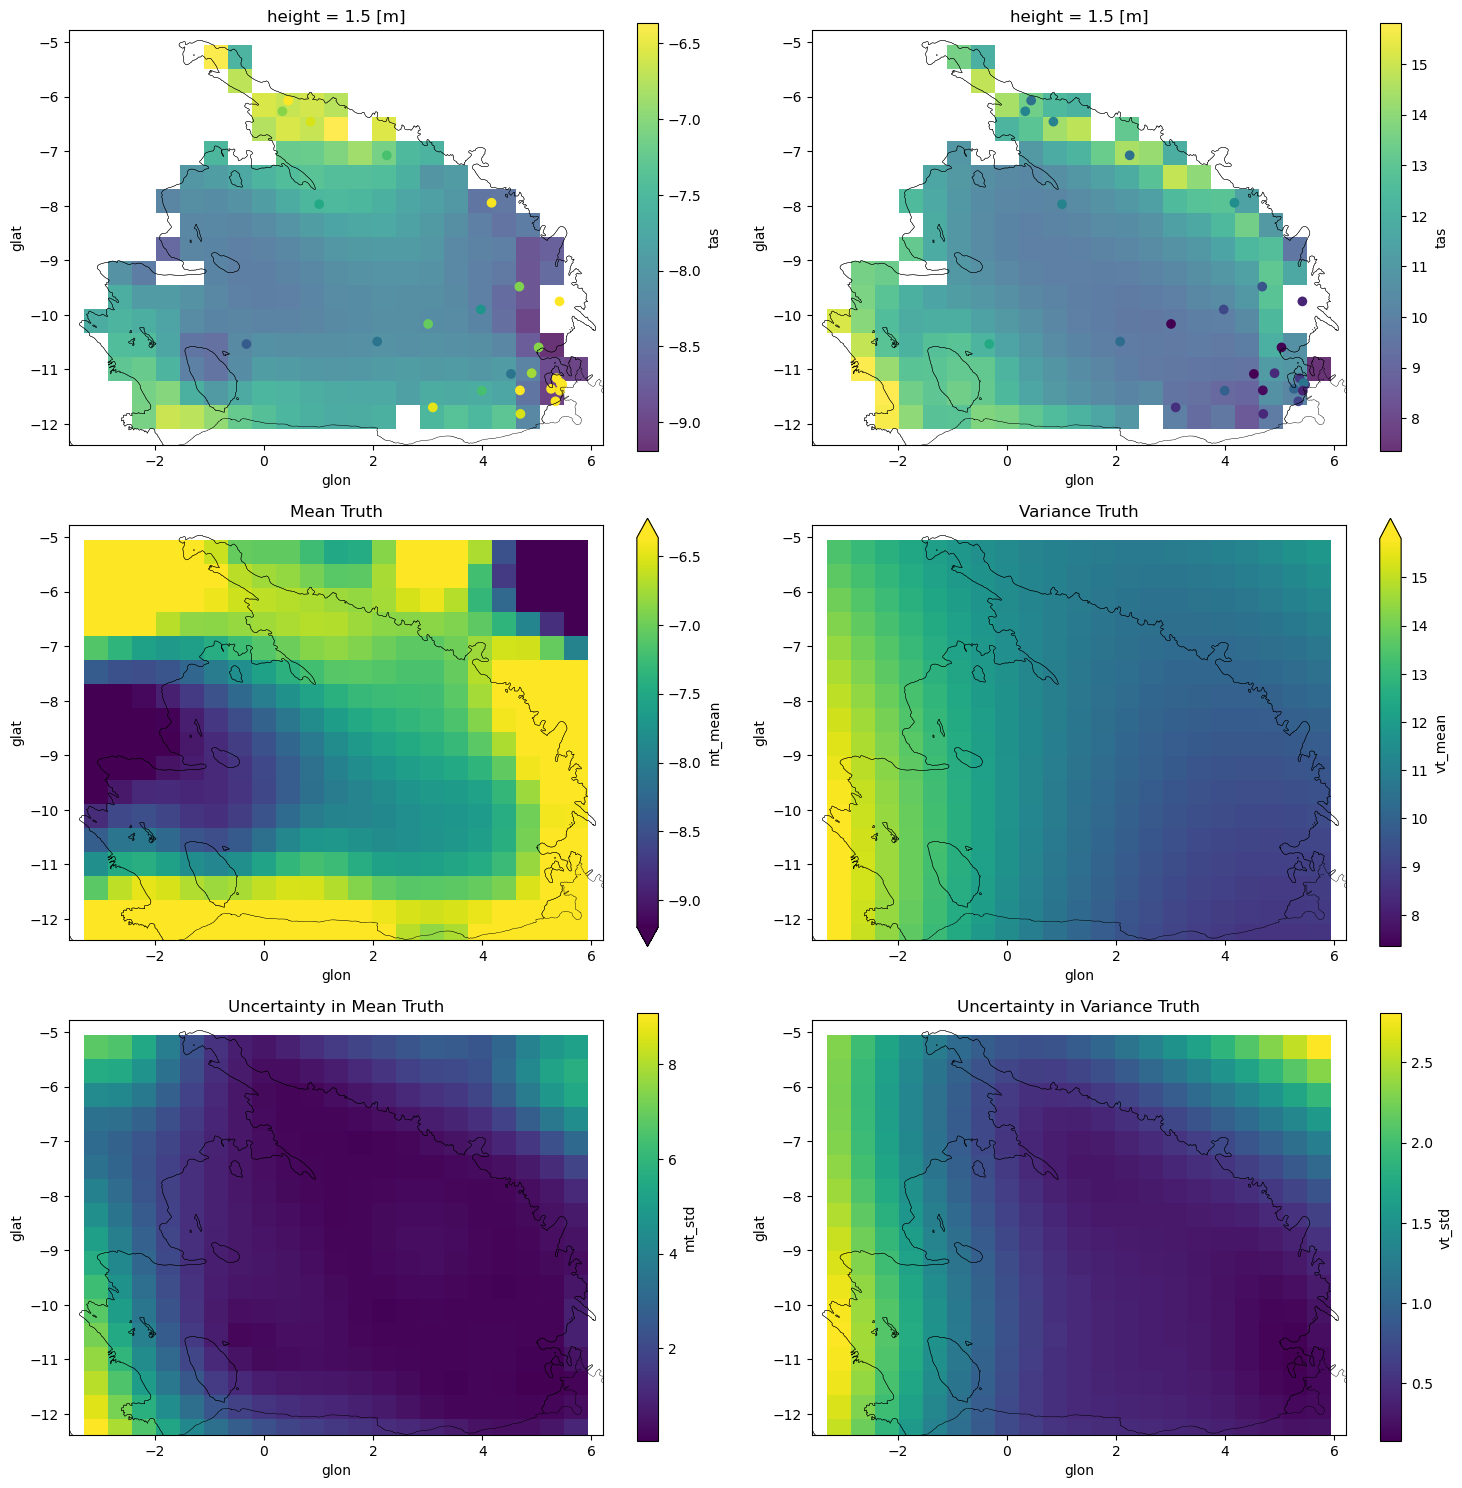

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
da = ds_climate['tas']
# da = da.isel(time=slice(None,None,10))

vmin_mean = da.mean('time').min()
vmax_mean = da.mean('time').max()
vmin_var = da.var('time').min()
vmax_var = da.var('time').max()

da.mean('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[0],alpha=0.8,vmin=vmin_mean,vmax=vmax_mean)
axs.ravel()[0].scatter(x=ox[:,0],y=ox[:,1],c=np.nanmean(odata,axis=0),vmin=vmin_mean,vmax=vmax_mean)

da.var('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[1],alpha=0.8,vmin=vmin_var,vmax=vmax_var)
axs.ravel()[1].scatter(x=ox[:,0],y=ox[:,1],c=np.nanvar(odata,axis=0),vmin=vmin_var,vmax=vmax_var)

for i,var,title in zip([3,5], ['mt_mean','mt_std'], ['Mean Truth','Uncertainty in Mean Truth']):
    plt.subplot(3, 2, i)
    if var=='mt_mean':
        vmin,vmax = vmin_mean,vmax_mean
    else:
        vmin,vmax = None,None
    # ds_predictions[var].plot.contourf(x='glon',y='glat',vmin=vmin,vmax=vmax)
    ds_predictions[var].plot.pcolormesh(x='glon',y='glat',vmin=vmin,vmax=vmax)
    plt.title(title)

for i,var,title in zip([4,6], ['vt_mean','vt_std'], ['Variance Truth','Uncertainty in Variance Truth']):
    plt.subplot(3, 2, i)
    if var=='vt_mean':
        vmin,vmax = vmin_var,vmax_var
    else:
        vmin,vmax = None,None
    # ds_predictions[var].plot.contourf(x='glon',y='glat',vmin=vmin,vmax=vmax)
    ds_predictions[var].plot.pcolormesh(x='glon',y='glat',vmin=vmin,vmax=vmax)
    plt.title(title)


min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

plt.tight_layout()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


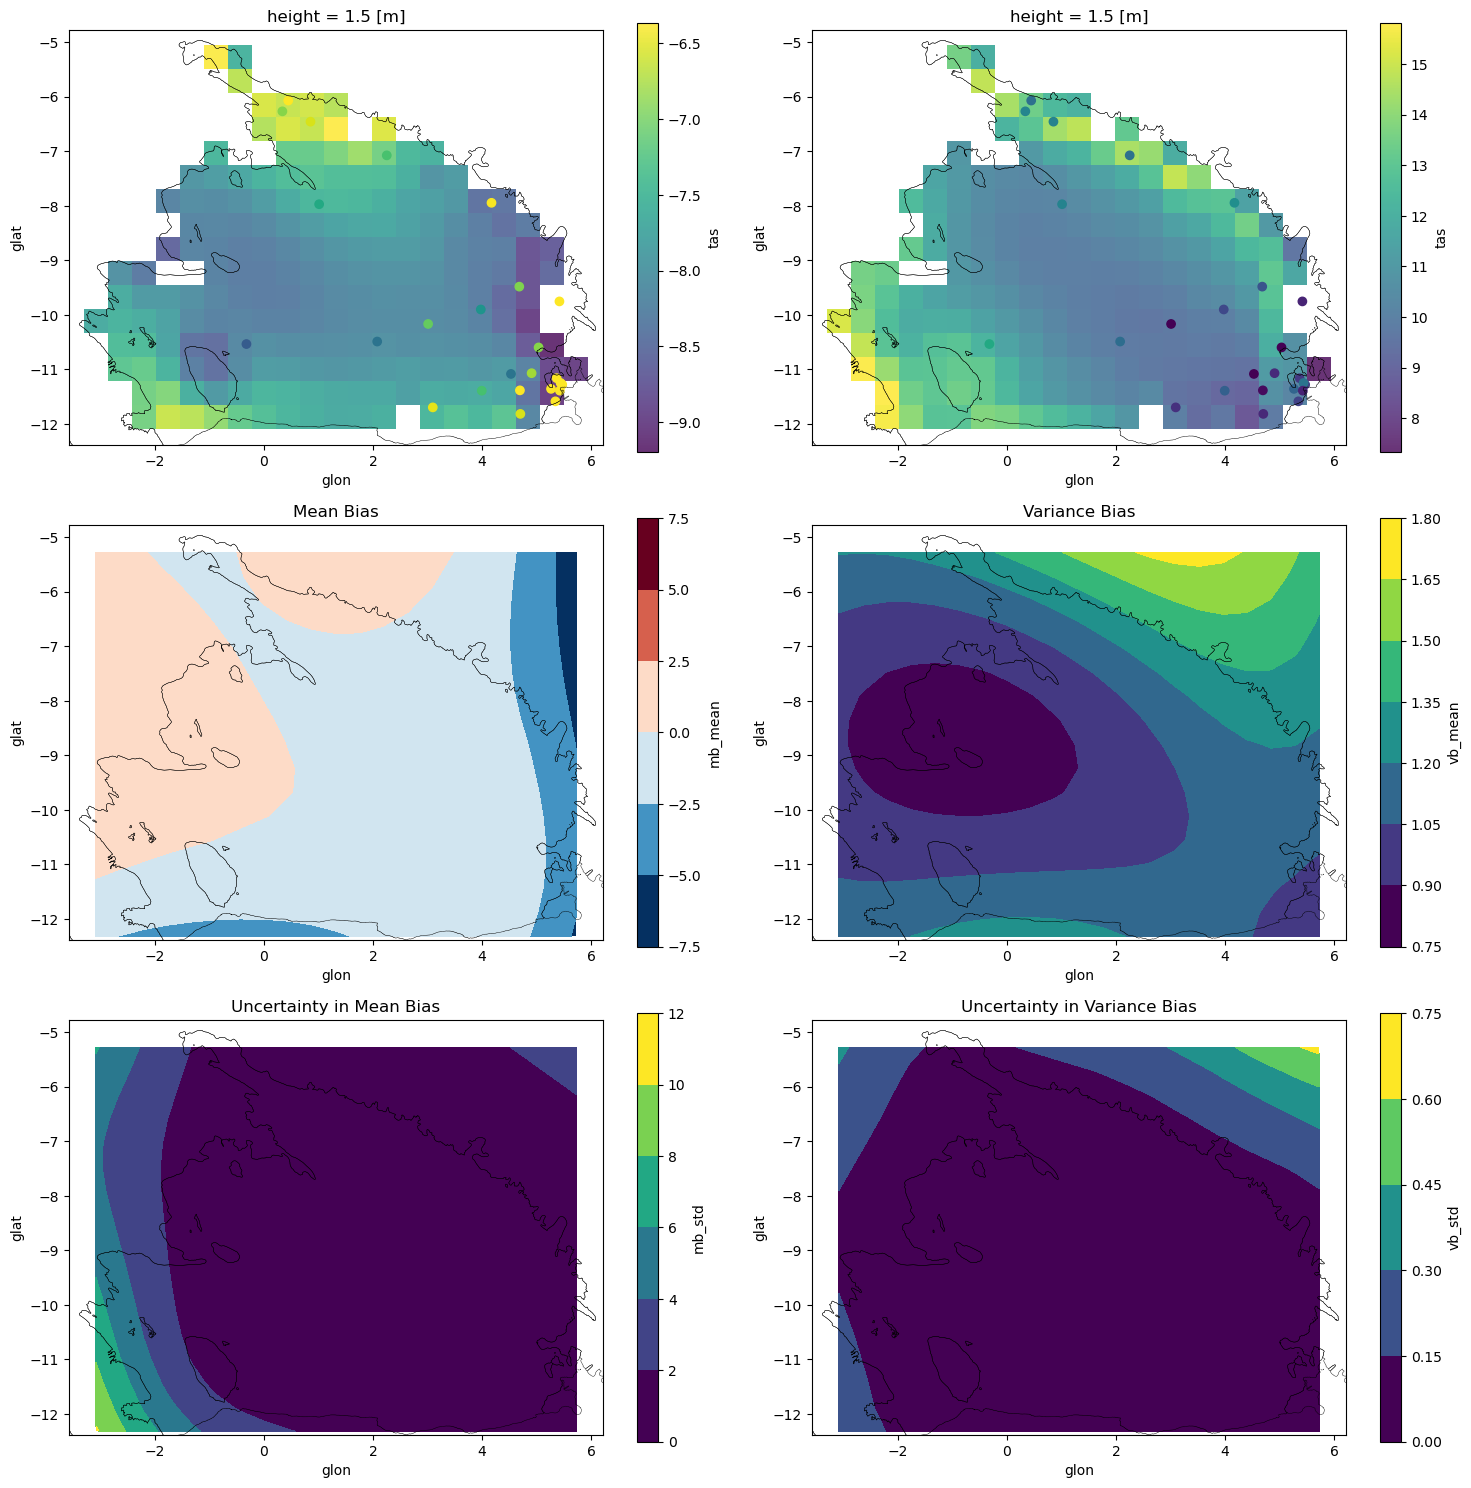

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
da = ds_climate['tas']
# da = da.isel(time=slice(None,None,10))

vmin_mean = da.mean('time').min()
vmax_mean = da.mean('time').max()
vmin_var = da.var('time').min()
vmax_var = da.var('time').max()

da.mean('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[0],alpha=0.8,vmin=vmin_mean,vmax=vmax_mean)
axs.ravel()[0].scatter(x=ox[:,0],y=ox[:,1],c=np.nanmean(odata,axis=0),vmin=vmin_mean,vmax=vmax_mean)

da.var('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[1],alpha=0.8,vmin=vmin_var,vmax=vmax_var)
axs.ravel()[1].scatter(x=ox[:,0],y=ox[:,1],c=np.nanvar(odata,axis=0),vmin=vmin_var,vmax=vmax_var)

for i,var,title in zip([3,5], ['mb_mean','mb_std'], ['Mean Bias','Uncertainty in Mean Bias']):
    plt.subplot(3, 2, i)
    ds_predictions[var].plot.contourf(x='glon',y='glat')
    plt.title(title)

for i,var,title in zip([4,6], ['vb_mean','vb_std'], ['Variance Bias','Uncertainty in Variance Bias']):
    plt.subplot(3, 2, i)
    ds_predictions[var].plot.contourf(x='glon',y='glat')
    plt.title(title)

min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

plt.tight_layout()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


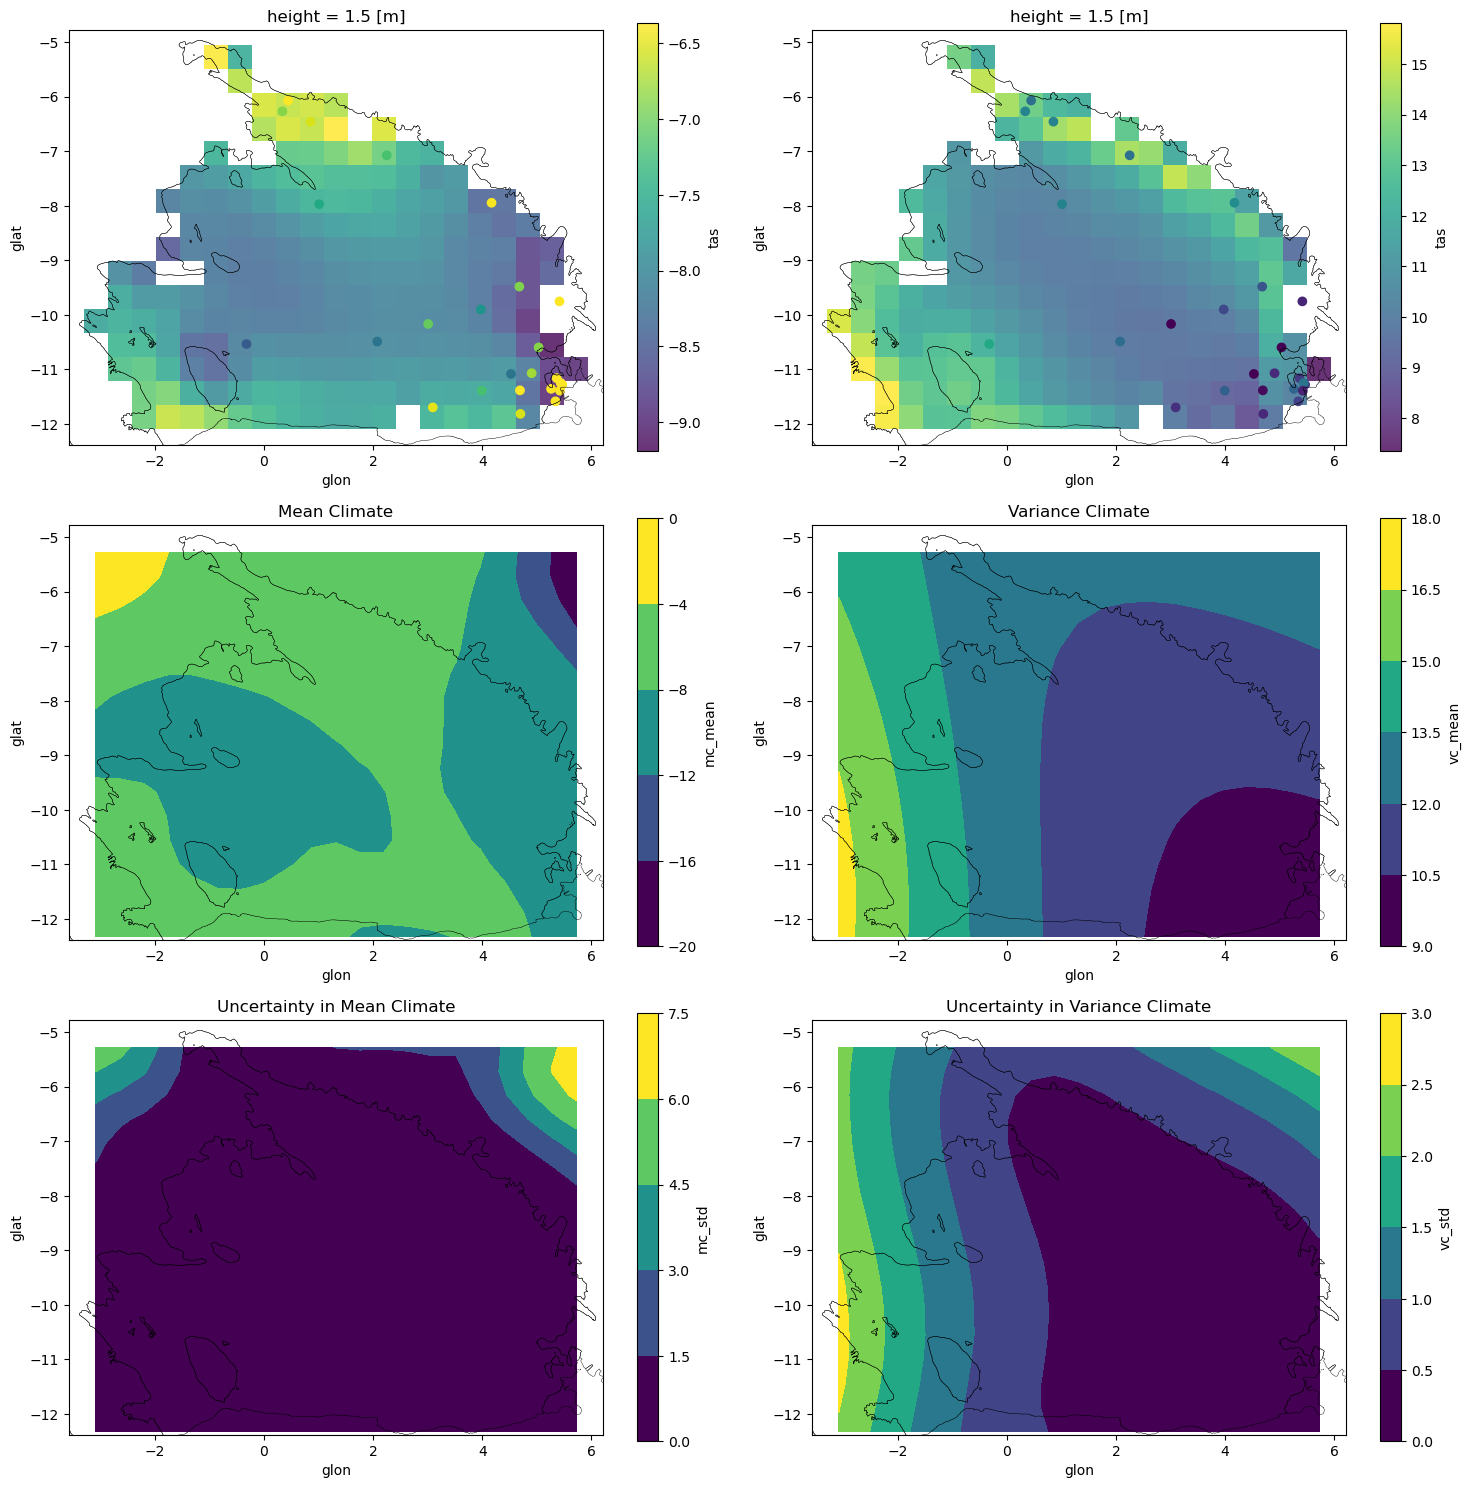

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
da = ds_climate['tas']
# da = da.isel(time=slice(None,None,10))

vmin_mean = da.mean('time').min()
vmax_mean = da.mean('time').max()
vmin_var = da.var('time').min()
vmax_var = da.var('time').max()

da.mean('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[0],alpha=0.8,vmin=vmin_mean,vmax=vmax_mean)
axs.ravel()[0].scatter(x=ox[:,0],y=ox[:,1],c=np.nanmean(odata,axis=0),vmin=vmin_mean,vmax=vmax_mean)

da.var('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[1],alpha=0.8,vmin=vmin_var,vmax=vmax_var)
axs.ravel()[1].scatter(x=ox[:,0],y=ox[:,1],c=np.nanvar(odata,axis=0),vmin=vmin_var,vmax=vmax_var)

for i,var,title in zip([3,5], ['mc_mean','mc_std'], ['Mean Climate','Uncertainty in Mean Climate']):
    plt.subplot(3, 2, i)
    ds_predictions[var].plot.contourf(x='glon',y='glat')
    plt.title(title)

for i,var,title in zip([4,6], ['vc_mean','vc_std'], ['Variance Climate','Uncertainty in Variance Climate']):
    plt.subplot(3, 2, i)
    ds_predictions[var].plot.contourf(x='glon',y='glat')
    plt.title(title)

min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

plt.tight_layout()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


NameError: name 'odata_sample' is not defined

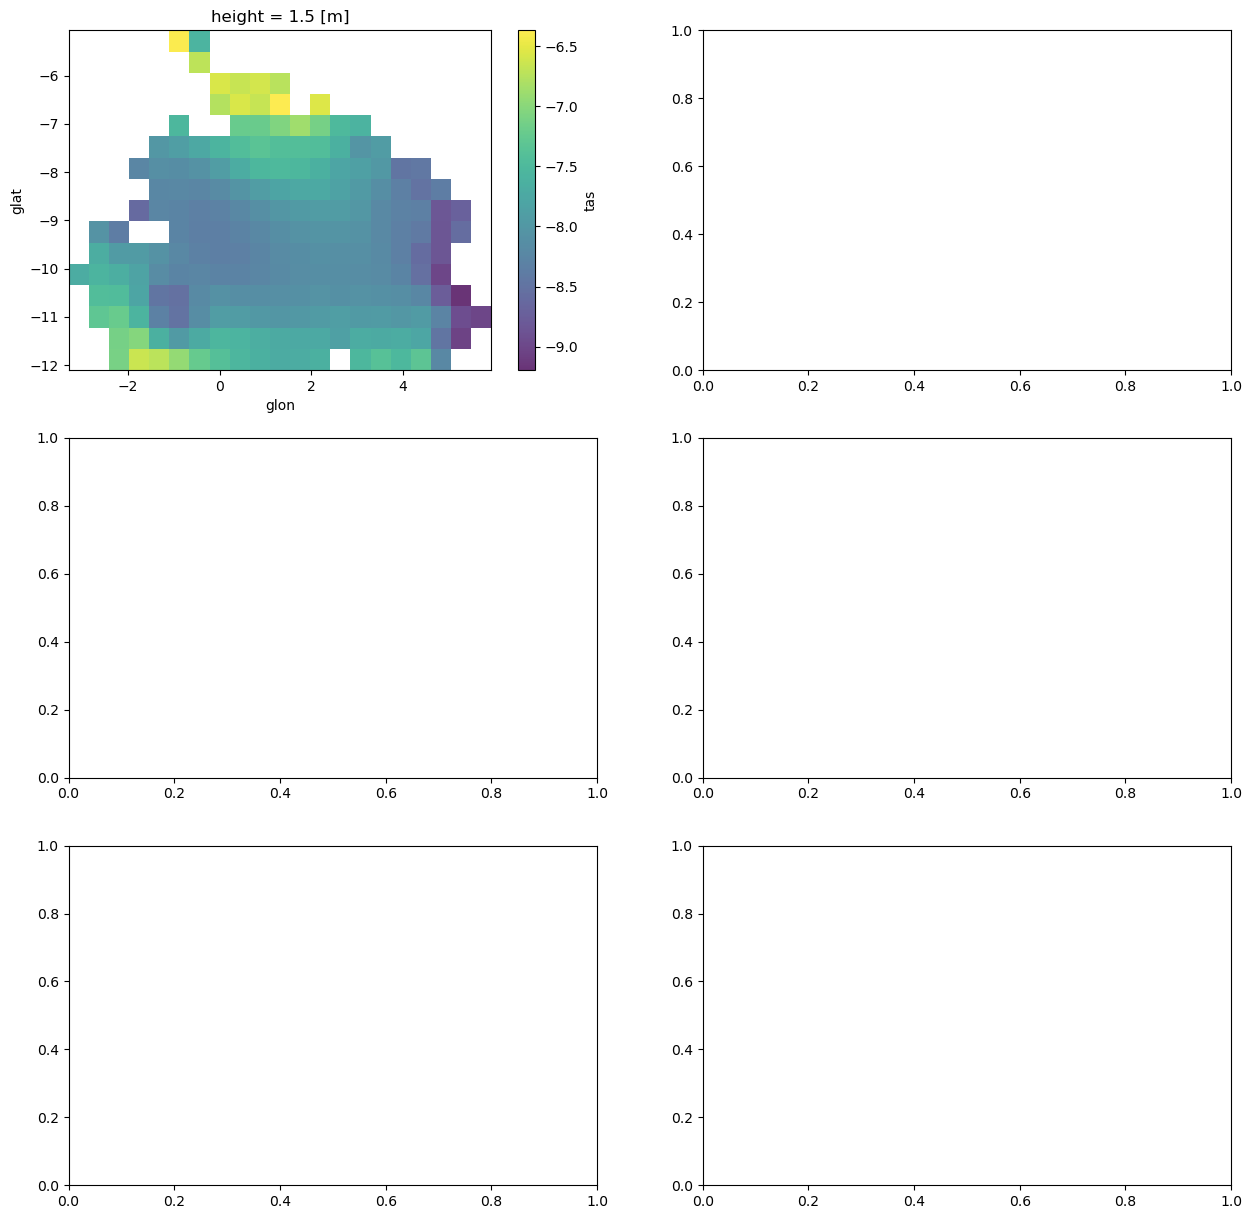

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
da = ds_climate['tas']
# da = da.isel(time=slice(None,None,10))

vmin_mean = da.mean('time').min()
vmax_mean = da.mean('time').max()
vmin_var = da.var('time').min()
vmax_var = da.var('time').max()

da.mean('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[0],alpha=0.8,vmin=vmin_mean,vmax=vmax_mean)
axs.ravel()[0].scatter(x=ox[:,0],y=ox[:,1],c=np.nanmean(odata_sample,axis=0),vmin=vmin_mean,vmax=vmax_mean)

da.var('time').plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[1],alpha=0.8,vmin=vmin_var,vmax=vmax_var)
axs.ravel()[1].scatter(x=ox[:,0],y=ox[:,1],c=np.nanvar(odata_sample,axis=0),vmin=vmin_var,vmax=vmax_var)

for i,var,title in zip([3,5], ['mc_mean','mc_std'], ['Mean Climate','Uncertainty in Mean Climate']):
    plt.subplot(3, 2, i)
    ds_predictions[var].plot.contourf(x='glon',y='glat')
    plt.title(title)